##### Faustine Delahousse, Ali Elhishi, Martin Drieux

## EA APM_52183_EP: Attention flow project

### **Notebook 1: Studying attention in HuggingFace Bert's sentiment analysis model.**



#### **0. Setting up the environment and necessary imports.**

In [ ]:
#Necessary upgrades and installation to set up the environment

!pip install transformers datasets --upgrade
!pip uninstall torch torchvision torchaudio -y
!pip cache purge
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # Install GPU version
!pip uninstall keras keras-nightly -y
!pip install tensorflow --upgrade
!pip install --upgrade accelerate

Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
Found existing installation: torchvision 0.21.0+cu118
Uninstalling torchvision-0.21.0+cu118:
  Successfully uninstalled torchvision-0.21.0+cu118
Found existing installation: torchaudio 2.6.0+cu118
Uninstalling torchaudio-2.6.0+cu118:
  Successfully uninstalled torchaudio-2.6.0+cu118
Files removed: 56
Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.7/848.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 67.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.18 requires torch<2.6,>=1.10, but you have torch 2.6.0+cu118 which is incompatible.


Found existing installation: keras 3.9.0
Uninstalling keras-3.9.0:
  Successfully uninstalled keras-3.9.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
^C
^C


In [ ]:
import torch

print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


GPU available: True
GPU name: Tesla T4


In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import load_dataset
from scipy.stats import spearmanr
import torch.nn.functional as F
import os
from sklearn.metrics import accuracy_score, f1_score
import networkx as nx
import random

#### **1. Prepping the models and datasets.**

In this part, we download the sst2 dataset which is ready for sentiment analysis (made of sentences and a label indicating a positive or negative sentiment).

We also download the bert models, the general one and the one with the classification head that we are going to finetune.
We download necessary dependencies such as the tokenizer and define the function that will allow us to get the attentions.

In [ ]:
# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Load BERT tokenizer : tokenizes input text into the format needed by BERT models
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


In [ ]:
def tokenize_function(examples):
  """
    In :
        examples : A dictionary containing a key "sentence" mapped to a list of sentences.

    Out :
        a dictionary containing:
            - 'input_ids' (list of list of int): Tokenized sentence IDs.
            - 'token_type_ids' (list of list of int): Identifies whether a token belongs to the first or second sentence (always 0 here).
            - 'attention_mask' (list of list of int): A mask indicating real tokens (1) and padding tokens (0).

    """
  return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# Tokenize the SST-2 dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

#get the automatic padder to make all sentences the same length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# get a pretrained bert model with the attention weigths
#this bert model just gives the embedding for a word depending on its context
model_pre = BertModel.from_pretrained("bert-base-uncased", output_attentions=True,attn_implementation="eager")

# Function to get attention matrices
def get_attention(model, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use gpu
    model.to(device)
    # transform the text into inputs adapted to Bert
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # move to gpu
    inputs = {k: v.to(device) for k, v in inputs.items()}
    # pass it into bert
    with torch.no_grad():
        outputs = model(**inputs,output_attentions=True)
    #get attention weights
    return outputs.attentions

# test de phrase avec sentiment positif
example_sentence = "This food tastes amazing!"

# attention before fine-tuning
attention_before = get_attention(model_pre, example_sentence)


#### **2. Comparing raw attentions before and after finetuning.**

In this part, we aim at comparing the effect of finetuning for sentiment analysis on raw attentions.

To do so, we compare the attentions weights of a Bert model that has been trained to handle text sentences to the same one that has been finetuned for sentiment analysis.
To do so, we train it on the SST2 dataset and check it has been trained correctly.

In [ ]:
# taking away the logging of métrics of huggingface for faster computation
os.environ["WANDB_DISABLED"] = "true"

#on réduit l'ensemble de train pour des raisons de vitesse principalement
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(2000))  # Only 2000 samples

# we fine-tune BERT on SST-2
#our goal is not to achieve amazing results but more to compare what happens to the attention when finetuning
training_args = TrainingArguments(
    #where to save the checkpoints
    output_dir="./results",
    # Skip evaluation during training
    evaluation_strategy="no",
    # Don't save checkpoints
    save_strategy="no",
    # Increase batch size
    per_device_train_batch_size=16,
    # Larger batch size for faster eval
    per_device_eval_batch_size=32,
    #only 1 epoch
    num_train_epochs=1,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=100,
    fp16=True,
    optim="adamw_torch_fused",
    dataloader_num_workers=4,
    report_to="none",
    gradient_accumulation_steps=4
)
# we add the classification head compared to model_pre
# the attention is computed in the layers and not the classification head so no difference
# the head is randomly initialized here as the model has not yet been trained
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-31-09dfe176fc37>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that 

Step,Training Loss
100,0.372500
200,0.256900
300,0.222900
400,0.197900
500,0.177600
600,0.171200
700,0.162800
800,0.166500
900,0.156300
1000,0.144200


TrainOutput(global_step=1052, training_loss=0.199686206792244, metrics={'train_runtime': 1505.6264, 'train_samples_per_second': 44.732, 'train_steps_per_second': 0.699, 'total_flos': 1.771474113527808e+16, 'train_loss': 0.199686206792244, 'epoch': 0.9995249406175772})

In [ ]:
# TESTING cheaply IF OUR MODEL WORKS OKAY

#text is the same sentence we will use to track attention on
# Tokenize input
inputs = tokenizer(example_sentence, return_tensors="pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get model prediction
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)

# logits into proba
logits = outputs.logits
probs = torch.nn.functional.softmax(logits, dim=-1)
predicted_label = torch.argmax(probs, dim=-1).item()

labels = ["Negative", "Positive"]
print(f"Sentence: {example_sentence}")
print(f"Predicted Sentiment: {labels[predicted_label]}")
print(f"Confidence: {probs[0][predicted_label].item():.4f}")

In [ ]:
# CHECKING THE ACCURACY OF THE TRAINED MODEL

# Extract a test set from examples 2001-2500
test_data = dataset["train"].select(range(2001, 2501))
test_texts = test_data["sentence"]
test_labels = test_data["label"]

# Tokenize inputs
inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")

# GPU
inputs = {k: v.to(device) for k, v in inputs.items()}

# Evaluate model
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Convert logits to predictions
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1).cpu().numpy()

# Compute metrics
accuracy = accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")



Accuracy: 0.9800
F1-score: 0.9808


We are reassured the "speed" choices we made did not compromise the accuracy too much (ampler tests would be necessary)

Now, we get the raw attention of the fine tuned model and we compare it to the initial raw attentions via the Spearman Correlation.

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


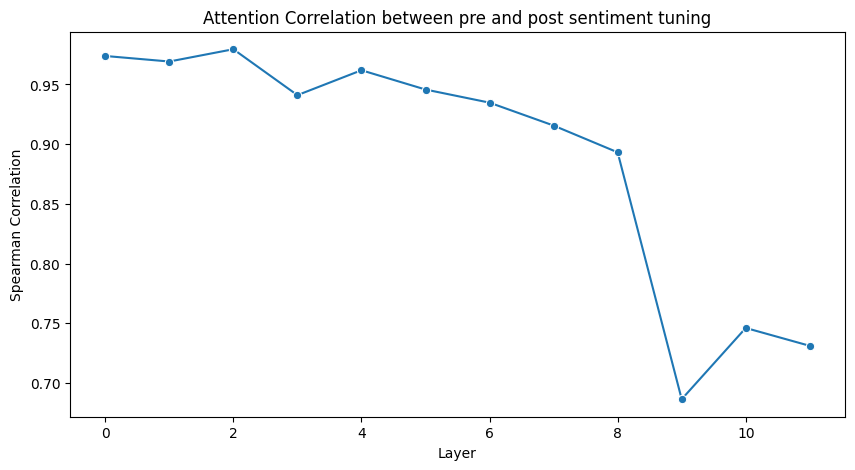

In [ ]:
# Get attention after fine-tuning
attention_after = get_attention(model, example_sentence)

# Compute Spearman correlation
correlations = []
#the bert model includes 12 layers
for layer in range(len(attention_before)):
     # Move tensors to CPU before converting to NumPy arrays
    before = attention_before[layer].squeeze().cpu().numpy()
    after = attention_after[layer].squeeze().cpu().numpy()
    #get the spearman correlation between 2 vectors : it measures how well the ranking of values in "before" matches the ranking in "after
    corr, _ = spearmanr(before.flatten(), after.flatten())
    correlations.append(corr)

# Plot the correlation across layers
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(correlations)), y=correlations, marker='o')
plt.xlabel("Layer")
plt.ylabel("Spearman Correlation")
plt.title("Attention Correlation between pre and post sentiment tuning")
plt.show()

What we observe is that the Spearman correlation is the lowest for the last layers. It proves that the finetuning happens mostly in the last layers of the models. The 10 to 12 layers are the one whose attention on the tokens differ as they aim at finding out sentiment analysis, whereas the first layers have a more general role of understanding the input sentence.


We continue the analysis of raw sentiments by plotting the heatmaps of the raw attention, especially in the last layer since we have determined it is the most impacted by the fine tuning.

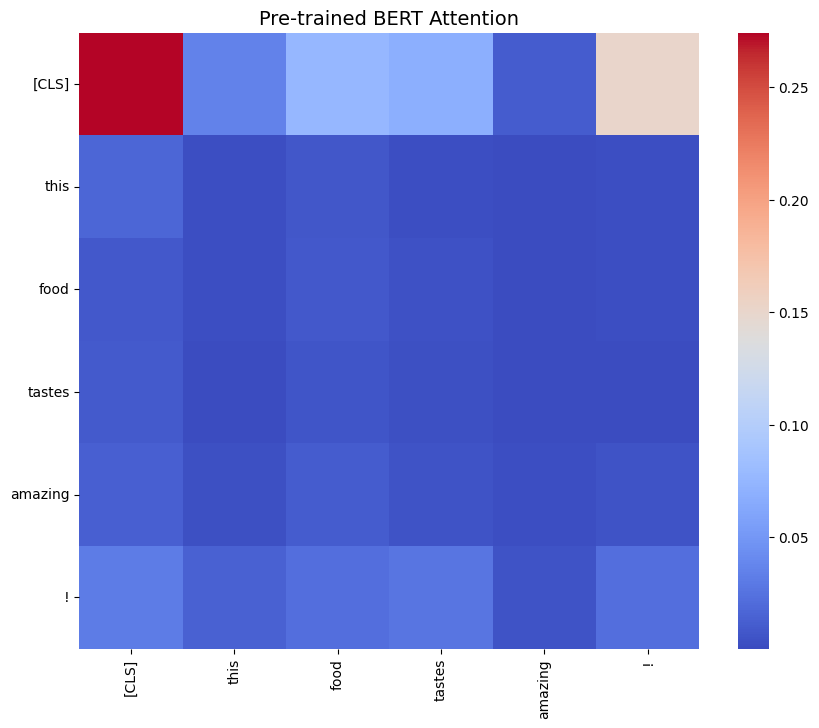

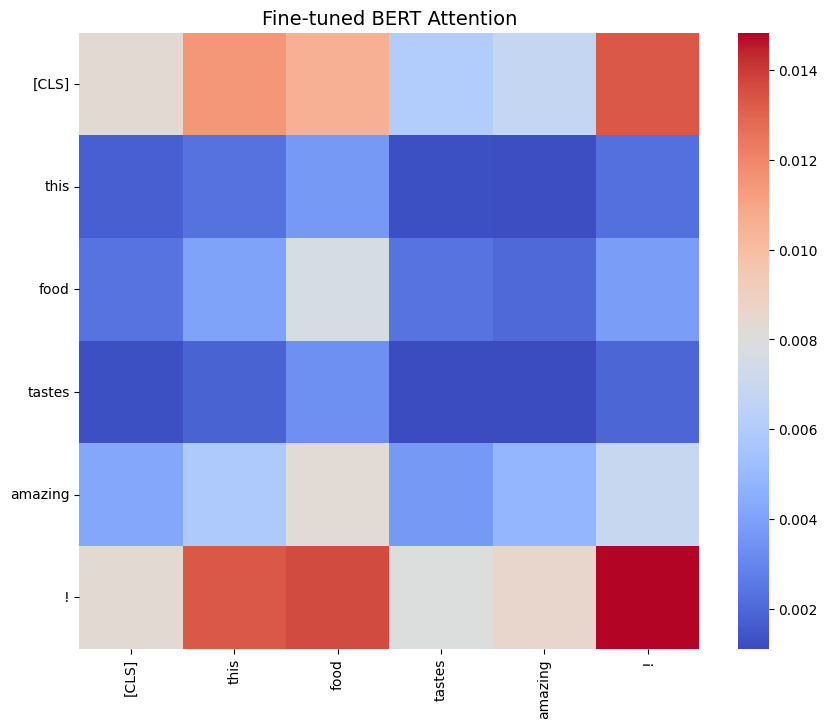

In [ ]:
def plot_attention_heatmap(attention_matrix, tokens, title):
    """Plots an improved attention heatmap with better readability."""
    attention_matrix = np.array(attention_matrix)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(attention_matrix, cmap="coolwarm", xticklabels=tokens, yticklabels=tokens, ax=ax)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_title(title, fontsize=14)
    plt.show()

# tokenize my own sentence
inputs = tokenizer(example_sentence, return_tensors="pt").to(device)

# getting the attention before fine-tuning
with torch.no_grad():
    outputs_pretrained = model_pre(**inputs,output_attentions=True)
attention_before = outputs_pretrained.attentions
# attention after fine-tuning
with torch.no_grad():
    outputs_finetuned = model(**inputs,output_attentions=True)
attention_after = outputs_finetuned.attentions

# choosing the layers (last one) and attention head
layer_idx = -1
head_idx = 0

before_attention = attention_before[layer_idx][0, head_idx].cpu().numpy()
after_attention = attention_after[layer_idx][0, head_idx].cpu().numpy()

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# taking away padding and separators as it is not explainable here
valid_tokens = [token for token in tokens if token != "[PAD]" and token != "[SEP]"]

seq_len = len(valid_tokens)

# matching attention matrices to valid tokens
before_attention = before_attention[:seq_len, :seq_len]
after_attention = after_attention[:seq_len, :seq_len]

plot_attention_heatmap(before_attention, valid_tokens, "Pre-trained BERT Attention")
plot_attention_heatmap(after_attention, valid_tokens, "Fine-tuned BERT Attention")



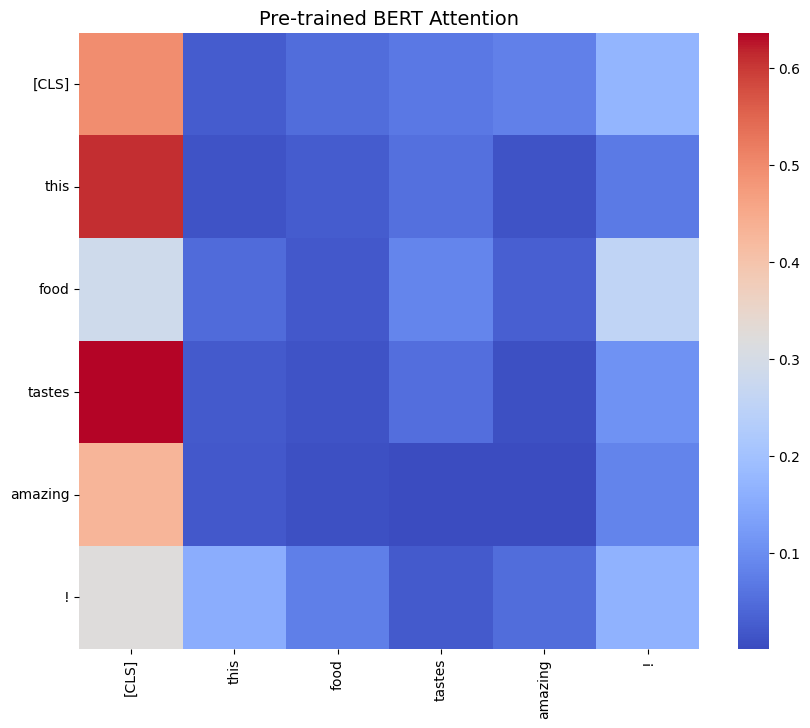

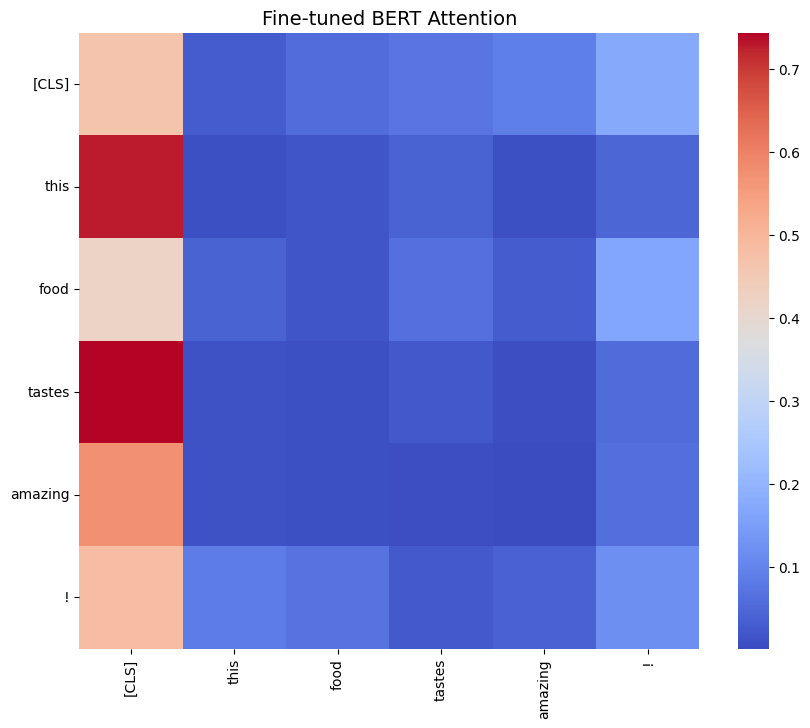

In [ ]:

# choosing the layers (last one) and attention head
layer_idx = 1
head_idx = 0

before_attention = attention_before[layer_idx][0, head_idx].cpu().numpy()
after_attention = attention_after[layer_idx][0, head_idx].cpu().numpy()

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# taking away padding and separators as it is not explainable here
valid_tokens = [token for token in tokens if token != "[PAD]" and token != "[SEP]"]

seq_len = len(valid_tokens)

# matching attention matrices to valid tokens
before_attention = before_attention[:seq_len, :seq_len]
after_attention = after_attention[:seq_len, :seq_len]

plot_attention_heatmap(before_attention, valid_tokens, "Pre-trained BERT Attention")
plot_attention_heatmap(after_attention, valid_tokens, "Fine-tuned BERT Attention")


We can see that the fine tuning impacts all layers. But notably for the last layer compared to the first layer the CLS classification token has updated the most.
That is consistent with the research paper.

However, the goal of this research paper is to go beyond raw attentions. Indeed, as seen with the heatmaps above the interpretability and power of what we can do with it can be limited, hence the interest in attention flow.

#### **3. Working with attention flow**

##### 3.1 Computing the attention flow.

In this part, we try to re-implement attention flow calculations and graphs using the 2020 "Quantifying Attention Flow in Transformers" paper from Abdnar and Zuidema.

In [ ]:
# We compute attention flow


def compute_attention_flow(model, tokenizer, sentence):
    """
    computes attention flow as  in the 2020 paper.

    with a trained BERT model and an input sentence, this function:
        extracts attention weights from all layers
        computes the attention flow matrix
        returns the final attention flow
    """

    inputs = tokenizer(sentence, return_tensors="pt").to(model.device)

    # forward pass to extract attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # extract attention matrices (list of tensors, one per layer)
    attention_matrices = outputs.attentions  # shape(num_layers, batch, num_heads, seq_len, seq_len)

    num_layers = len(attention_matrices)
    seq_len = attention_matrices[0].shape[-1]

    #  aggregate attention over heads (mean over heads)
    att_matrices = np.array([layer.squeeze().mean(dim=0).cpu().numpy() for layer in attention_matrices])

    # initialize identity matrix for flow propagation
    attention_flow = np.eye(seq_len)

    # compute attention flow across layers
    for layer in range(num_layers):
        A = att_matrices[layer]
        A /= A.sum(axis=-1, keepdims=True)
        attention_flow = np.matmul(attention_flow, A)

    return attention_flow, inputs

example_sentence = "This movie was incredibly well-made and deeply moving."
flow_matrix, inputs = compute_attention_flow(model, tokenizer, example_sentence)

# print the final attention flow matrix
print("Final Attention Flow Matrix:")
print(flow_matrix)

Final Attention Flow Matrix:
[[0.00821777 0.01483095 0.01165559 0.01374774 0.01098269 0.01415188
  0.01172891 0.00786013 0.01385897 0.01069665 0.0098995  0.01088446
  0.86148502]
 [0.00821777 0.01483095 0.01165559 0.01374774 0.01098269 0.01415188
  0.01172891 0.00786013 0.01385897 0.01069665 0.0098995  0.01088446
  0.86148507]
 [0.00821777 0.01483096 0.01165559 0.01374774 0.01098269 0.01415188
  0.01172891 0.00786013 0.01385897 0.01069666 0.0098995  0.01088446
  0.86148513]
 [0.00821777 0.01483096 0.01165559 0.01374774 0.01098269 0.01415188
  0.01172891 0.00786013 0.01385897 0.01069666 0.0098995  0.01088446
  0.86148509]
 [0.00821777 0.01483096 0.01165559 0.01374774 0.01098269 0.01415188
  0.01172891 0.00786013 0.01385897 0.01069666 0.0098995  0.01088446
  0.86148514]
 [0.00821777 0.01483096 0.01165559 0.01374774 0.01098269 0.01415188
  0.01172892 0.00786013 0.01385897 0.01069666 0.0098995  0.01088446
  0.86148515]
 [0.00821777 0.01483096 0.01165559 0.01374774 0.01098269 0.01415188
  0

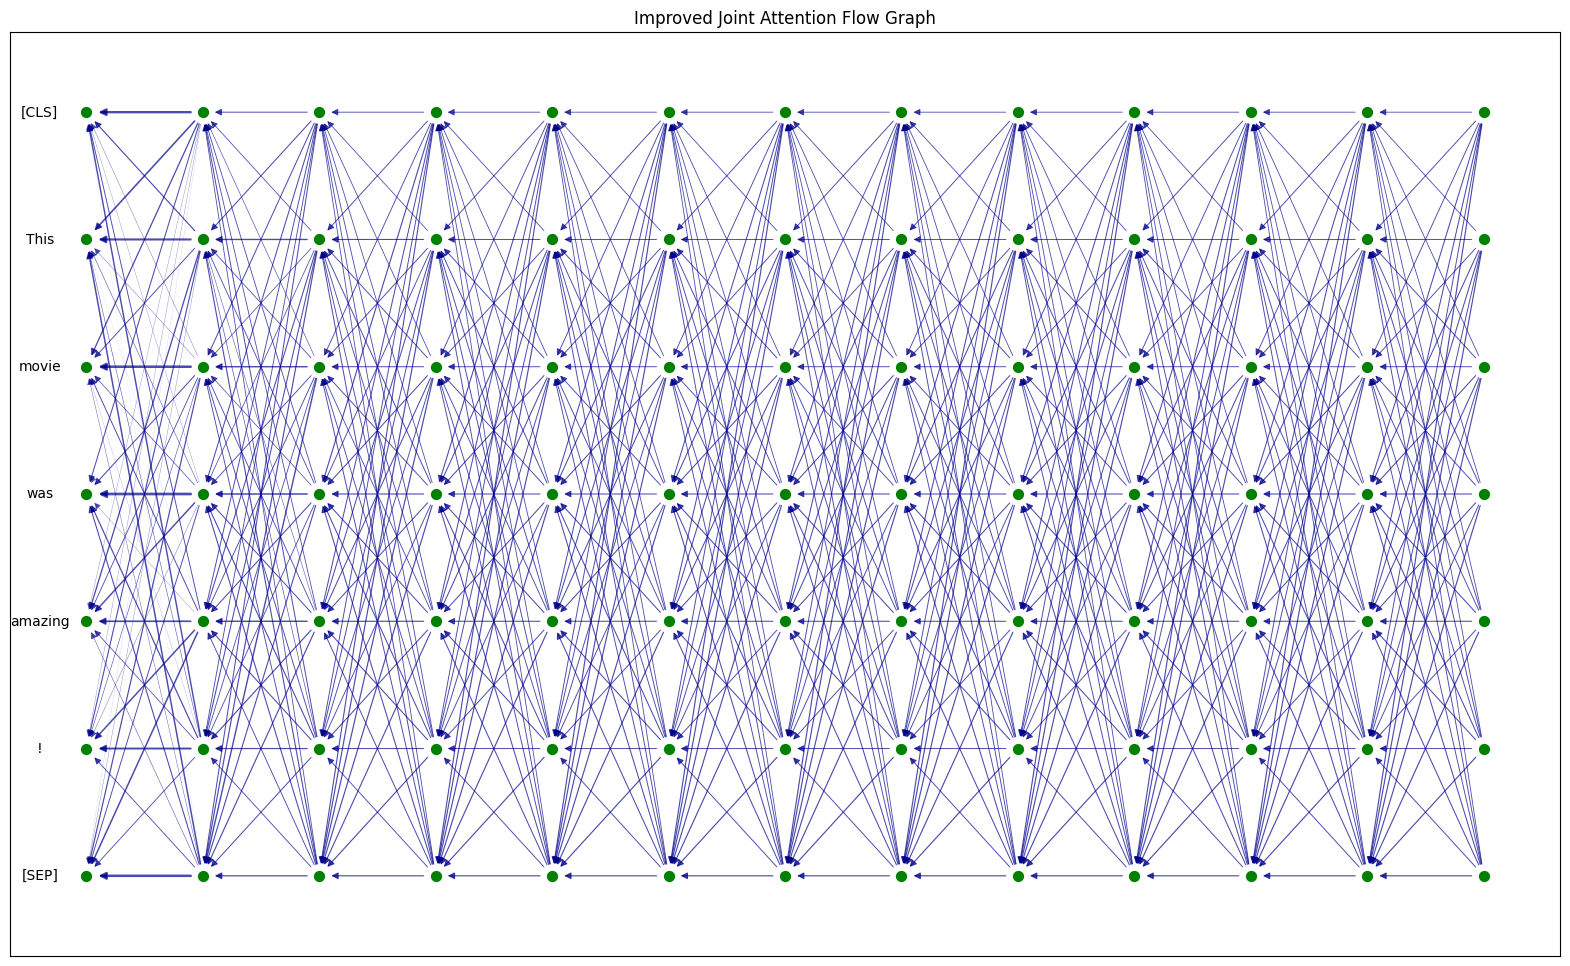

In [ ]:
# getting the attention flow graphs
#These functions come from the implementation of the paper

def compute_joint_attention(att_mat, add_residual=True):

    if add_residual:
        residual_att = np.eye(att_mat.shape[1])[None, ...]
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(axis=-1)[..., None]
    else:
        aug_att_mat = att_mat

    joint_attentions = np.zeros_like(aug_att_mat)
    joint_attentions[0] = aug_att_mat[0]

    # accumulating attention across layers
    for i in range(1, aug_att_mat.shape[0]):
        joint_attentions[i] = aug_att_mat[i].dot(joint_attentions[i - 1])

    return joint_attentions

def get_adjmat(mat, input_tokens):
    """
    Constructs an adjacency matrix representing the joint attention flow graph.
    """
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers + 1) * length, (n_layers + 1) * length))
    labels_to_index = {}

    # map input tokens to index
    for k in range(length):
        labels_to_index[f"{k}_{input_tokens[k]}"] = k

    for i in range(1, n_layers + 1):
        for k_f in range(length):
            index_from = i * length + k_f
            label = f"L{i}_{k_f}"
            labels_to_index[label] = index_from
            for k_t in range(length):
                index_to = (i - 1) * length + k_t
                adj_mat[index_from][index_to] = mat[i - 1][k_f][k_t]

    return adj_mat, labels_to_index

def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    """
    draws the attention flow graph
    """
    G = nx.from_numpy_array(adjmat, create_using=nx.DiGraph())

    # edge capacities = weights
    for i in range(adjmat.shape[0]):
        for j in range(adjmat.shape[1]):
            nx.set_edge_attributes(G, {(i, j): adjmat[i, j]}, 'capacity')


    pos = {}
    label_pos = {}
    for i in range(n_layers + 1):
        for k_f in range(length):
            pos[i * length + k_f] = ((i + 0.4) * 2, length - k_f)
            label_pos[i * length + k_f] = (i * 2, length - k_f)

    index_to_labels = {v: k.split("_")[-1] for k, v in labels_to_index.items()}
    for key in labels_to_index:
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    plt.figure(figsize=(20, 12))

    nx.draw_networkx_nodes(G, pos, node_color='green', node_size=50)
    nx.draw_networkx_labels(G, pos=label_pos, labels=index_to_labels, font_size=10)


    all_weights = [data['capacity'] for (_, _, data) in G.edges(data=True)]
    unique_weights = list(set(all_weights))

    # draw the edges with dependant thickness
    for weight in unique_weights:
        weighted_edges = [(node1, node2) for (node1, node2, edge_attr) in G.edges(data=True) if edge_attr['capacity'] == weight]
        width = weight * 5
        nx.draw_networkx_edges(G, pos, edgelist=weighted_edges, width=width, edge_color='darkblue', alpha=0.7)

    plt.title("Improved Joint Attention Flow Graph")
    plt.show()

# FAKE example to check the visualization
tokens = ["[CLS]", "This", "movie", "was", "amazing", "!", "[SEP]"]
res_att_mat = np.random.rand(12, len(tokens), len(tokens))  # Replace with real attention matrices
joint_attentions = compute_joint_attention(res_att_mat, add_residual=True)
joint_att_adjmat, joint_labels_to_index = get_adjmat(joint_attentions, tokens)
draw_attention_graph(joint_att_adjmat, joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])


In [ ]:

def get_attention_matrices_github_style(model, tokenizer, sentence):
    """
    Extracts raw attention matrices from all layers in a trained BERT model,
    following the GitHub method (sum over heads + residual connection).
    """
    # Tokenize input sentence
    inputs = tokenizer(sentence, return_tensors="pt").to(model.device)

    # Forward pass to get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention matrices (Shape: num_layers, batch, num_heads, seq_len, seq_len)
    attentions_mat = np.array([layer.squeeze().cpu().numpy() for layer in outputs.attentions])

    # Apply GitHub-style computation: Sum over heads & add identity
    res_att_mat = attentions_mat.sum(axis=1) / attentions_mat.shape[1]
    res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None, ...]  # residual
    res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[..., None]

    return res_att_mat, inputs


example_sentence=" the food here is amazing, so delicious !"

res_att_mat, inputs = get_attention_matrices_github_style(model, tokenizer, example_sentence)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
# Check shape of extracted attention matrices
print(f"Shape of res_att_mat: {res_att_mat.shape}")  # Expected: (num_layers, seq_len, seq_len)


Shape of res_att_mat: (12, 11, 11)


Tokenized words: ['[CLS]', 'the', 'food', 'here', 'is', 'amazing', ',', 'so', 'delicious', '!', '[SEP]']
Number of tokens in tokens list: 11
Expected length from att_mat: 11


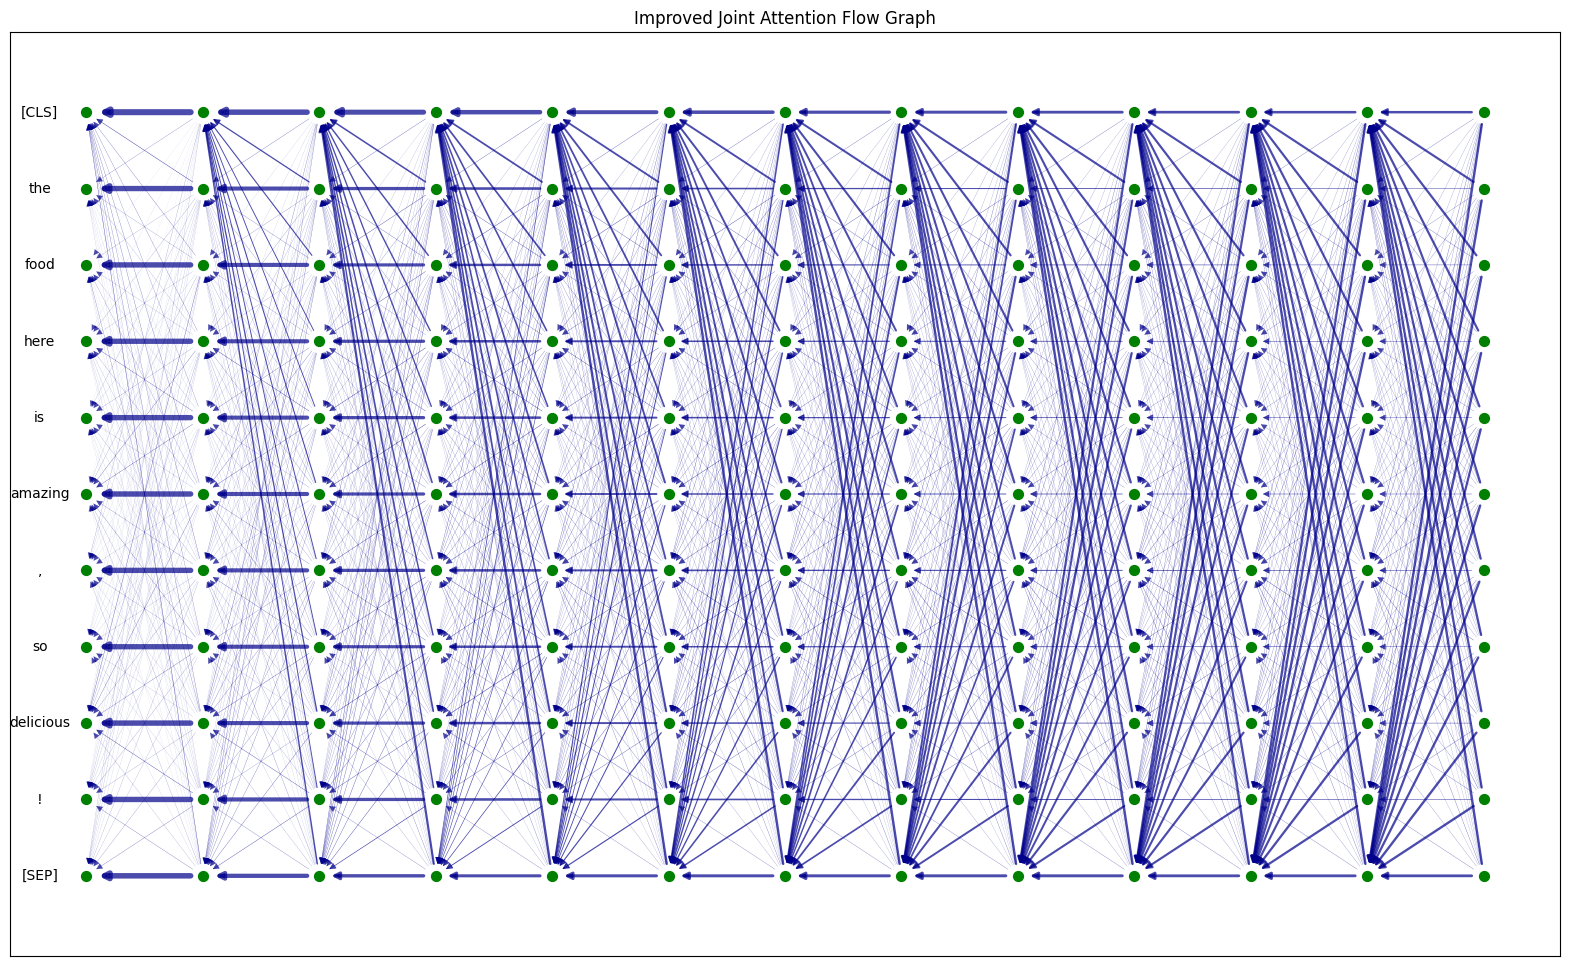

In [ ]:
# Compute Joint Attention
joint_attentions = compute_joint_attention(res_att_mat, add_residual=True)
print(f"Tokenized words: {tokens}")
print(f"Number of tokens in tokens list: {len(tokens)}")
print(f"Expected length from att_mat: {res_att_mat.shape[-1]}")

# Convert to adjacency matrix
joint_att_adjmat, joint_labels_to_index = get_adjmat(joint_attentions, tokens)

# Draw the Attention Flow graph
draw_attention_graph(joint_att_adjmat, joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])


We have succeded in getting the visualization of the flow.

Now, our goal is to see the relevance of attention flow in the performance of the sentiment classification.

##### 3.2 Perturbating the embedding of the most important words - attention-flow-wise.


In this part, we want to check how the accuracy of the classification decreases depending on if we perturbate the embedding of random words, maximum flow words or minimum flow words.

In [ ]:
# We select the 2 most important words in a phrase defining an important word as one whose attention flow
# to the classificator token is high

def get_important_words(flow_matrix, tokens, top_n=2):
    """
    Identify the most important words based on their attention flow to [CLS].
    Excludes special tokens like [CLS], [SEP], and [PAD].
    """
    cls_index = tokens.index("[CLS]")  # index of CLS
    cls_flow = flow_matrix[cls_index]  # Extract `[CLS]` flow to all tokens

    # excluding special tokens
    valid_indices = [i for i, token in enumerate(tokens) if token not in ["[CLS]", "[SEP]", "[PAD]"]]

    filtered_cls_flow = np.array([cls_flow[i] for i in valid_indices])


    important_word_indices = np.argsort(-filtered_cls_flow)[:top_n]
    important_words = [tokens[valid_indices[i]] for i in important_word_indices]

    return important_words, [valid_indices[i] for i in important_word_indices]


important_words, important_indices = get_important_words(joint_attentions[-1], tokens)

print(f"Important words: {important_words}")
print(f"Indices of important words: {important_indices}")


Important words: ['!', ',']
Indices of important words: [9, 6]


In [ ]:
# we do the symmetrical function but for least important words
def get_least_important_words(flow_matrix, tokens, top_n=2):

    cls_index = tokens.index("[CLS]")  #  index of CLS
    cls_flow = flow_matrix[cls_index]  # Extract `[CLS]` flow to all tokens

    # exclude special tokens
    valid_indices = [i for i, token in enumerate(tokens) if token not in ["[CLS]", "[SEP]", "[PAD]"]]

    filtered_cls_flow = np.array([cls_flow[i] for i in valid_indices])

    # identify least important words (lowest attention flow)
    least_important_word_indices = np.argsort(filtered_cls_flow)[:top_n]
    least_important_words = [tokens[valid_indices[i]] for i in least_important_word_indices]

    return least_important_words, [valid_indices[i] for i in least_important_word_indices]


least_important_words, least_important_indices = get_least_important_words(joint_attentions[-1], tokens)  # Use last layer

print(f"Least Important Words: {least_important_words}")
print(f"Indices of Least Important Words: {least_important_indices}")


Least Important Words: ['food', 'is']
Indices of Least Important Words: [2, 4]


In [ ]:
# We define a function that extracts the embedding for research purpose
def extract_embeddings(model, tokenizer, sentence):
    """
    Get token embeddings from BERT's embedding layer.
    """
    inputs = tokenizer(sentence, return_tensors="pt").to(device)

    with torch.no_grad():
        embeddings = model.embeddings.word_embeddings(inputs["input_ids"])

    return embeddings, inputs


original_embeddings, inputs = extract_embeddings(model_pre, tokenizer, example_sentence)
print(original_embeddings)

tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [-0.0446,  0.0061, -0.0022,  ..., -0.0363, -0.0004, -0.0306],
         [-0.0179, -0.0035, -0.0022,  ..., -0.0005,  0.0112, -0.0379],
         ...,
         [-0.0316, -0.0666,  0.0139,  ..., -0.0094, -0.0904, -0.0536],
         [ 0.0298, -0.0373, -0.0356,  ...,  0.0161,  0.0192,  0.0173],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]]],
       device='cuda:0')


In [ ]:


def perturb_important_embeddings(embeddings, inputs, tokenizer, important_words, epsilon=0.1):
    """
    Finds the embeddings of important words and perturbs them with noise.
    """
    # Get tokenized words
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Find the positions of important words (including subwords)
    word_indices = [i for i, token in enumerate(tokens) if token in important_words]

    if not word_indices:
        print(f"Warning: None of the important words {important_words} found in tokenized input!")
        return embeddings  # Return unmodified embeddings

    # Apply perturbation (adding small noise)
    perturbed_embeddings = embeddings.clone()
    for idx in word_indices:
        perturbed_embeddings[0, idx] += epsilon * torch.randn_like(perturbed_embeddings[0, idx])

    return perturbed_embeddings

# Perturb embeddings of all important words
perturbed_embeddings = perturb_important_embeddings(original_embeddings, inputs, tokenizer, important_words)


In [ ]:
#We now want to compare the performance of the fine-tuned BERT model on a test set
#depending on if we perturbate or not the important words

def evaluate_model_on_test_set(model, tokenizer, dataset, perturb=False, epsilon=0.1):
    """
    Evaluates model accuracy on a test set, with or without perturbation.
    """
    # extract a test set from examples 2001-2500
    test_data = dataset["train"].select(range(2001, 2501))
    test_texts = test_data["sentence"]
    test_labels = test_data["label"]

    inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # extracting embeddings if perturbation is applied
    if perturb:
        embedding_model = BertModel.from_pretrained("bert-base-uncased").to(device)

        # Extract original embeddings
        with torch.no_grad():
            original_embeddings = embedding_model.embeddings.word_embeddings(inputs["input_ids"])

        # perturb important words
        perturbed_embeddings = original_embeddings.clone()
        for i, text in enumerate(test_texts):

            att_mat, tokenized_inputs = get_attention_matrices_github_style(model, tokenizer, text)
            joint_attentions = compute_joint_attention(att_mat, add_residual=True)
            tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][0])
            important_words, important_indices = get_important_words(joint_attentions[-1], tokens)

            # apply the perturbation
            for idx in important_indices:
                perturbed_embeddings[i, idx] += epsilon * torch.randn_like(perturbed_embeddings[i, idx])

        # replace embeddings in the inputs
        inputs["inputs_embeds"] = perturbed_embeddings
        del inputs["input_ids"]

    # evaluate model
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    # compute the metrics
    accuracy = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)

    return accuracy, f1

# evaluate on clean test set
clean_accuracy, clean_f1 = evaluate_model_on_test_set(model, tokenizer, dataset, perturb=False)
print(f"Original Model Accuracy: {clean_accuracy:.4f}")
print(f"Original Model F1-score: {clean_f1:.4f}")

# evaluate on perturbed test set
perturbed_accuracy, perturbed_f1 = evaluate_model_on_test_set(model, tokenizer, dataset, perturb=True, epsilon=0.1)
print(f"Perturbed Model Accuracy: {perturbed_accuracy:.4f}")
print(f"Perturbed Model F1-score: {perturbed_f1:.4f}")


Original Model Accuracy: 0.9800
Original Model F1-score: 0.9808
Perturbed Model Accuracy: 0.8780
Perturbed Model F1-score: 0.8806


We are pleased with these results as they do show that the accuracy is lower by 10% when the important words are perturbated.
But we need to check that this is due to the nature of the perturbation that is to say its focus on flow-wise important words and not just the fact that there is a perturbation.

Therefore now we compute a function that picks 2 random words.

In [ ]:

def get_random_words(tokens, n):
    """
    Selects a random set of words from the tokenized sentence. The number is fixes by n
    (we will choose it equal to the number of 'important words' when comparing )
    Excludes [CLS], [SEP], and [PAD] but keeps punctuation.
    """
    valid_indices = [i for i, token in enumerate(tokens) if token not in ["[CLS]", "[SEP]", "[PAD]"]]

    if len(valid_indices) < n:
        num_words = len(valid_indices)  # Avoid errors if too few words

    return random.sample(valid_indices, n)  # Pick random indices


def evaluate_model_on_test_set(model, tokenizer, dataset, perturb=False, perturb_type="targeted", epsilon=0.1):
    """
    Evaluates model accuracy on a test set with or without perturbation and if with 2 different perturbation possible:
    perturb_type:
      - "targeted": Perturb words identified via Attention Flow
      - "random" -> Perturb random words
    """

    test_data = dataset["train"].select(range(2001, 2501))
    test_texts = test_data["sentence"]
    test_labels = test_data["label"]


    inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")

    inputs = {k: v.to(device) for k, v in inputs.items()}


    if perturb:
        embedding_model = BertModel.from_pretrained("bert-base-uncased").to(device)


        with torch.no_grad():
            original_embeddings = embedding_model.embeddings.word_embeddings(inputs["input_ids"])


        perturbed_embeddings = original_embeddings.clone()
        for i, text in enumerate(test_texts):

            att_mat, tokenized_inputs = get_attention_matrices_github_style(model, tokenizer, text)
            joint_attentions = compute_joint_attention(att_mat, add_residual=True)
            tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][0])

            if perturb_type == "targeted":

                important_words, important_indices = get_important_words(joint_attentions[-1], tokens)
            elif perturb_type == "random":
               # Get same num of words as if targeted
                num_words = len(get_important_words(joint_attentions[-1], tokens)[0])
                important_indices = get_random_words(tokens, num_words)

            # apply perturbation
            for idx in important_indices:
                perturbed_embeddings[i, idx] += epsilon * torch.randn_like(perturbed_embeddings[i, idx])

        # replace embeddings in the inputs and remove `input_ids`
        inputs["inputs_embeds"] = perturbed_embeddings
        del inputs["input_ids"]

    # Evaluate model
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to predictions
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    # Compute metrics
    accuracy = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)

    return accuracy, f1

# Run evaluation on clean test set (Baseline)
clean_accuracy, clean_f1 = evaluate_model_on_test_set(model, tokenizer, dataset, perturb=False)
print(f"Original Model Accuracy: {clean_accuracy:.4f}")
print(f"Original Model F1-score: {clean_f1:.4f}")

# Run evaluation with targeted perturbation (important words)
targeted_accuracy, targeted_f1 = evaluate_model_on_test_set(model, tokenizer, dataset, perturb=True, perturb_type="targeted", epsilon=0.1)
print(f"Targeted Perturbation Accuracy: {targeted_accuracy:.4f}")
print(f"Targeted Perturbation F1-score: {targeted_f1:.4f}")

# Run evaluation with random perturbation (random words)
random_accuracy, random_f1 = evaluate_model_on_test_set(model, tokenizer, dataset, perturb=True, perturb_type="random", epsilon=0.1)
print(f"Random Perturbation Accuracy: {random_accuracy:.4f}")
print(f"Random Perturbation F1-score: {random_f1:.4f}")


Original Model Accuracy: 0.9800
Original Model F1-score: 0.9808
Targeted Perturbation Accuracy: 0.8840
Targeted Perturbation F1-score: 0.8885
Random Perturbation Accuracy: 0.9060
Random Perturbation F1-score: 0.9084


Once again we are satisfied by the fact that the accuracy is indeed lower when targetting important words. Now we want to establish that this is true for varied perturbation intensities to ensure it is not just a one-point phenomenon.

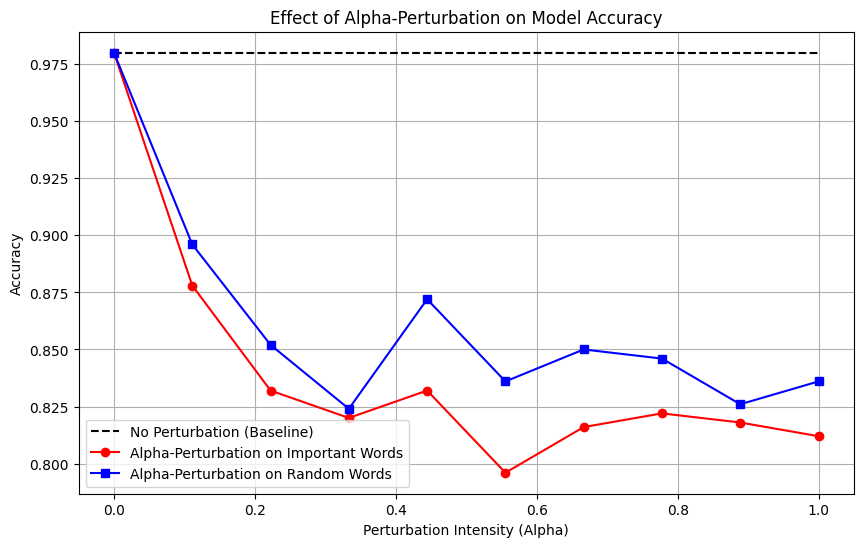

In [ ]:

# same function to evaluate accuracy with different perturbation but with the possibility to choose
# the intensity of the perturbation
def evaluate_model_on_test_set(model, tokenizer, perturb=False, perturb_type="targeted", epsilon=0.1):

    test_data = dataset["train"].select(range(2001, 2501))
    test_texts = test_data["sentence"]
    test_labels = test_data["label"]

    inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt").to(device)
    if perturb:
        embedding_model = BertModel.from_pretrained("bert-base-uncased").to(device)


        with torch.no_grad():
            original_embeddings = embedding_model.embeddings.word_embeddings(inputs["input_ids"])


        perturbed_embeddings = original_embeddings.clone()
        for i, text in enumerate(test_texts):

            att_mat, tokenized_inputs = get_attention_matrices_github_style(model, tokenizer, text)
            joint_attentions = compute_joint_attention(att_mat, add_residual=True)
            tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][0])

            if perturb_type == "targeted":

                important_words, important_indices = get_important_words(joint_attentions[-1], tokens)
            elif perturb_type == "random":
               # Get same num of words as if targeted
                num_words = len(get_important_words(joint_attentions[-1], tokens)[0])
                important_indices = get_random_words(tokens, num_words)

            # apply perturbation
            for idx in important_indices:
                perturbed_embeddings[i, idx] += epsilon * torch.randn_like(perturbed_embeddings[i, idx])

        # replace embeddings in the inputs and remove `input_ids`
        inputs["inputs_embeds"] = perturbed_embeddings
        del inputs["input_ids"]

    # Evaluate model
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to predictions
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    # Compute metrics
    accuracy = accuracy_score(test_labels, predictions)

    return accuracy

# choosing the perturbation intensity range
alpha_values = np.linspace(0, 1, 10)

# store accuracy results
accuracies_clean = []
accuracies_targeted = []
accuracies_random = []

# evaluate model performance for different alpha values
for alpha in alpha_values:
    # baseline accuracy (computed once)
    if not accuracies_clean:
        clean_accuracy = evaluate_model_on_test_set(model, tokenizer, perturb=False)
        accuracies_clean.append(clean_accuracy)

    # accuracy with targeted perturbation (important words)
    targeted_accuracy = evaluate_model_on_test_set(model, tokenizer, perturb=True, perturb_type="targeted", epsilon=alpha)
    accuracies_targeted.append(targeted_accuracy)

    # accuracy with random perturbation (random words)
    random_accuracy = evaluate_model_on_test_set(model, tokenizer, perturb=True, perturb_type="random", epsilon=alpha)
    accuracies_random.append(random_accuracy)


plt.figure(figsize=(10, 6))
plt.plot(alpha_values, accuracies_clean * len(alpha_values), label="No Perturbation (Baseline)", linestyle="--", color="black")
plt.plot(alpha_values, accuracies_targeted, label="Alpha-Perturbation on Important Words", marker="o", color="red")
plt.plot(alpha_values, accuracies_random, label="Alpha-Perturbation on Random Words", marker="s", color="blue")

plt.xlabel("Perturbation Intensity (Alpha)")
plt.ylabel("Accuracy")
plt.title("Effect of Alpha-Perturbation on Model Accuracy")
plt.legend()
plt.grid(True)
plt.show()


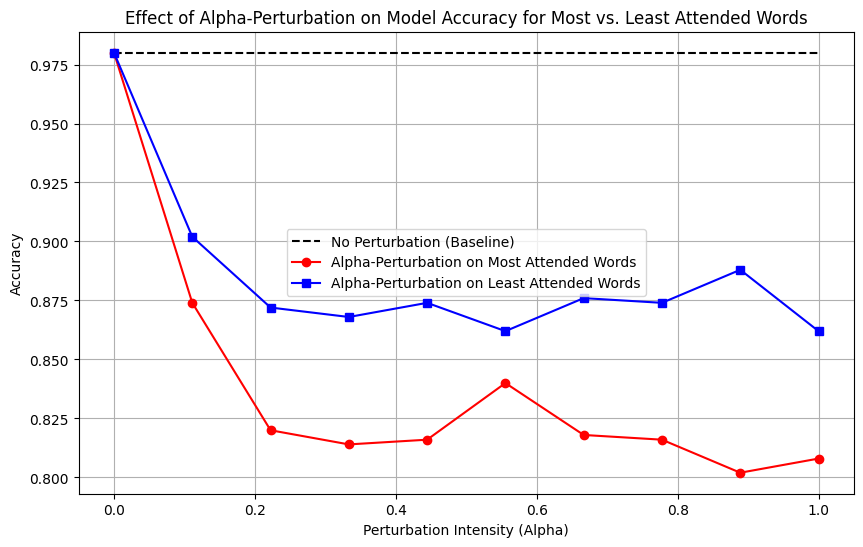

In [ ]:
# Now we compare the accuracy when targetting least important and most important words


def evaluate_model_on_test_set(model, tokenizer, perturb=False, perturb_type="high", epsilon=0.1):
    """
    evaluates model accuracy on a test set, with or without perturbation and if with : .
    perturb_type:
      - "high" -> Perturb words with the most attention
      - "low" -> Perturb words with the least attention
    """
    torch.cuda.empty_cache()

    test_data = dataset["train"].select(range(2001, 2501))
    test_texts = test_data["sentence"]
    test_labels = test_data["label"]
    inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt").to(device)
    if perturb:
        embedding_model = BertModel.from_pretrained("bert-base-uncased").to(device)


        with torch.no_grad():
            original_embeddings = embedding_model.embeddings.word_embeddings(inputs["input_ids"])


        perturbed_embeddings = original_embeddings.clone()
        for i, text in enumerate(test_texts):

            att_mat, tokenized_inputs = get_attention_matrices_github_style(model, tokenizer, text)
            joint_attentions = compute_joint_attention(att_mat, add_residual=True)
            tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][0])

            if perturb_type == "high":

                important_words, important_indices = get_important_words(joint_attentions[-1], tokens)
            elif perturb_type == "low":
               # Get same num of words as if targeted
                mportant_words, important_indices = get_least_important_words(joint_attentions[-1], tokens)

            # apply perturbation
            for idx in important_indices:
                perturbed_embeddings[i, idx] += epsilon * torch.randn_like(perturbed_embeddings[i, idx])

        # replace embeddings in the inputs and remove `input_ids`
        inputs["inputs_embeds"] = perturbed_embeddings
        del inputs["input_ids"]

    # Evaluate model
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to predictions
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    # Compute metrics
    accuracy = accuracy_score(test_labels, predictions)

    return accuracy

# Define range of alpha values (perturbation intensity)
alpha_values = np.linspace(0, 1, 10)  # From 0 (no perturbation) to 1 (max perturbation)

# Store accuracy results
accuracies_clean = []
accuracies_high_attention = []
accuracies_low_attention = []

# Evaluate model performance for different alpha values
for alpha in alpha_values:
    torch.cuda.empty_cache()  # Free memory before each iteration

    # Baseline accuracy (computed once)
    if not accuracies_clean:
        clean_accuracy = evaluate_model_on_test_set(model, tokenizer, perturb=False)
        accuracies_clean.append(clean_accuracy)

    # Accuracy with high attention perturbation (most attended words)
    high_attention_accuracy = evaluate_model_on_test_set(model, tokenizer, perturb=True, perturb_type="high", epsilon=alpha)
    accuracies_high_attention.append(high_attention_accuracy)

    # Accuracy with low attention perturbation (least attended words)
    low_attention_accuracy = evaluate_model_on_test_set(model, tokenizer, perturb=True, perturb_type="low", epsilon=alpha)
    accuracies_low_attention.append(low_attention_accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, accuracies_clean * len(alpha_values), label="No Perturbation (Baseline)", linestyle="--", color="black")
plt.plot(alpha_values, accuracies_high_attention, label="Alpha-Perturbation on Most Attended Words", marker="o", color="red")
plt.plot(alpha_values, accuracies_low_attention, label="Alpha-Perturbation on Least Attended Words", marker="s", color="blue")

plt.xlabel("Perturbation Intensity (Alpha)")
plt.ylabel("Accuracy")
plt.title("Effect of Alpha-Perturbation on Model Accuracy for Most vs. Least Attended Words")
plt.legend()
plt.grid(True)
plt.show()


We are reassured again that the accuracy decreases more when the most important words attention wise are targeted.



#### **4. Working with attention rollout**

Now we want to implement the same approach with attention rollout.



##### 4.1. Computing the attention rollout

We take inspiration from the 2020 paper to compute attention roll out.

In [ ]:

def compute_attention_rollout(attention_matrices, add_residual=True):
    """
    Compute Attention Rollout across Transformer layers.
    - If `add_residual=True`, it adds identity connections (residual attention).
    - Propagates attention cumulatively across layers.
    """
    num_layers = attention_matrices.shape[0]  # Number of layers
    seq_len = attention_matrices.shape[-1]  # Sequence length

    # Add identity matrix for residual connection
    if add_residual:
        residual_att = np.eye(seq_len)[None, ...]  # Shape: (1, seq_len, seq_len)
        augmented_att = attention_matrices + residual_att
        augmented_att = augmented_att / augmented_att.sum(axis=-1, keepdims=True)  # Normalize
    else:
        augmented_att = attention_matrices  # No residual

    # Initialize rollout with first layer's attention
    rollout_attention = np.copy(augmented_att[0])

    # Accumulate attention across layers
    for i in range(1, num_layers):
        rollout_attention = augmented_att[i] @ rollout_attention  # Matrix multiplication

    return rollout_attention

def compute_attention_rollout_last(attention_matrices, add_residual=True):
    """Compute Attention Rollout across Transformer layers and return the final matrix."""
    num_layers = attention_matrices.shape[0]
    seq_len = attention_matrices.shape[-1]

    if add_residual:
        residual_att = np.eye(seq_len)[None, ...]
        augmented_att = attention_matrices + residual_att
        augmented_att /= augmented_att.sum(axis=-1, keepdims=True)
    else:
        augmented_att = attention_matrices

    rollout_attention = np.copy(augmented_att[0])  # Start from first layer

    for i in range(1, num_layers):
        rollout_attention = augmented_att[i] @ rollout_attention  # Matrix multiplication

    return rollout_attention[-1]  # Return the last layer's aggregated attention

def get_attention_matrices(model, tokenizer, sentence):
    """
    Extracts raw attention matrices from all layers in a trained BERT model.
    """
    # Tokenize sentence
    inputs = tokenizer(sentence, return_tensors="pt").to(model.device)

    # Forward pass to get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Convert to NumPy (Shape: num_layers x num_heads x seq_len x seq_len)
    attention_matrices = np.array([layer.cpu().numpy() for layer in outputs.attentions])

    # Sum over all heads (reducing from num_heads to single matrix per layer)
    attention_matrices = attention_matrices.mean(axis=1)

    return attention_matrices, inputs

# Run Attention Rollout
sentence = "The movie was absolutely fantastic!"
attention_matrices, inputs = get_attention_matrices(model, tokenizer, sentence)
rollout_attention = compute_attention_rollout_last(attention_matrices)

# Print rolled-out attention (CLS token attention to all words)
cls_attention = rollout_attention[0]  # Extract attention flow from [CLS]
print(f"Attention Rollout for CLS: {cls_attention}")


Attention Rollout for CLS: [0.65988919 0.05704464 0.0198983  0.02835634 0.02787518 0.03388873
 0.01272705 0.16032056]


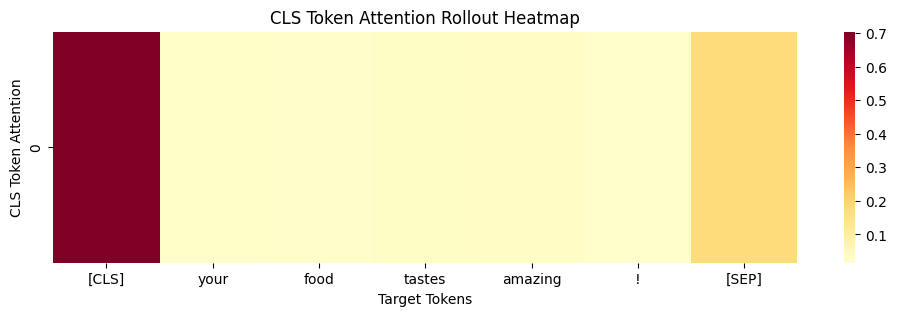

In [ ]:

def visualize_cls_attention_rollout(rollout_attention, tokens, title="CLS Attention Rollout Heatmap"):
    """
    Visualizes the final attention rollout specifically for the [CLS] token.

    Parameters:
    - rollout_attention: The final attention rollout matrix (shape: seq_len x seq_len).
    - tokens: The list of tokens in the sequence.
    - title: Title of the heatmap plot.
    """
    cls_index = 0  # [CLS] token is always at index 0
    cls_attention = rollout_attention[cls_index].reshape(1, -1)  # Extract CLS row attention

    plt.figure(figsize=(12, 3))
    sns.heatmap(cls_attention, xticklabels=tokens, cmap="YlOrRd", annot=False)
    plt.title(title)
    plt.xlabel("Target Tokens")
    plt.ylabel("CLS Token Attention")
    plt.show()

# Compute attention matrices for fine-tuned model
torch.cuda.empty_cache()
example_sentence = "your food tastes amazing !"
attention_matrices, inputs = get_attention_matrices(model, tokenizer, example_sentence)
rollout_attention = compute_attention_rollout_last(attention_matrices)  # Compute final rollout

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Free memory
del model
torch.cuda.empty_cache()

# Visualize CLS attention rollout as a heatmap
visualize_cls_attention_rollout(rollout_attention, tokens, title="CLS Token Attention Rollout Heatmap")

This heatmap shows how much attention the [CLS] token gives to each word in the sentence after processing through all layers of the model. The [CLS] token mostly focuses on itself, meaning that its final representation is built from its own information rather than directly from the other words. The words in the sentence, like "food" and "amazing", receive very little attention from [CLS], which suggests that their importance is spread across different layers rather than being strongly connected to the final decision. The [SEP] token gets some attention, likely because it helps structure the sentence. This shows that BERT builds an overall understanding of the sentence rather than focusing on specific words at the final stage.

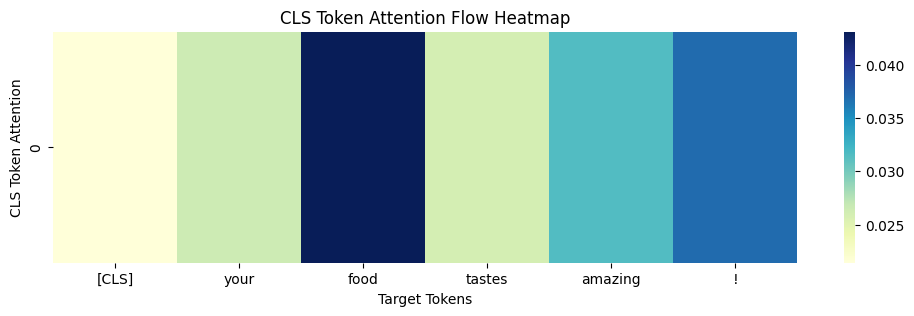

In [ ]:
def visualize_cls_attention_flow(flow_matrix, tokens, title="CLS Token Attention Flow Heatmap"):
    """
    Visualizes the final attention flow for the [CLS] token,
    ensuring correct filtering of special tokens.
    """
    cls_index = 0  # [CLS] token is at index 0
    cls_attention = flow_matrix[cls_index]  # Extract CLS row attention

    # Ensure valid indices by filtering out only [SEP], keeping [CLS] at index 0
    valid_tokens = [token for i, token in enumerate(tokens) if token not in ["[SEP]"]]
    valid_indices = [i for i, token in enumerate(tokens) if token not in ["[SEP]"]]

    # Filter attention values using valid indices
    filtered_attention = np.take(cls_attention, valid_indices, mode='clip').reshape(1, -1)

    plt.figure(figsize=(12, 3))
    sns.heatmap(filtered_attention, xticklabels=valid_tokens, cmap="YlGnBu", annot=False)
    plt.title(title)
    plt.xlabel("Target Tokens")
    plt.ylabel("CLS Token Attention")
    plt.show()

# Compute attention flow for the fine-tuned model
flow_matrix, inputs = compute_attention_flow(model, tokenizer, example_sentence)

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Visualize CLS attention flow as a heatmap
visualize_cls_attention_flow(flow_matrix, tokens, title="CLS Token Attention Flow Heatmap")


The attention flow is more explainable, as the paper also concludes.

##### 4.2 Perturbating the embedding of the most important words - attention-rollout-wise.

When studying the project attention roll out also came to our attention, notably because that is the attention method used within the vitexplain image project that we also wanted to understand. Therefore we implement the same perturbation of the embedding technique, to see if there are differences with the attention rollout. We are expecting it to work less given the findings in the 2020 paper.

In [ ]:
def get_important_words_rollout(rollout_attention, tokens, top_n=2):
    """
    Identify the most important words based on their final attention rollout to [CLS].
    Excludes special tokens like [CLS], [SEP], and [PAD].

    Parameters:
    - rollout_attention: The final attention rollout matrix (shape: seq_len x seq_len).
    - tokens: The list of tokens in the sequence.
    - top_n: Number of most important words to select.

    Returns:
    - important_words: List of most important words based on rollout attention.
    - important_indices: Corresponding indices of those words in the sequence.
    """
    cls_index = 0  # [CLS] token is always at index 0
    cls_rollout = rollout_attention[cls_index]  # Extract CLS attention to all tokens

    # Exclude special tokens
    valid_indices = [i for i, token in enumerate(tokens) if token not in ["[CLS]", "[SEP]", "[PAD]"]]

    # Filter rollout attention for valid tokens
    filtered_rollout = np.array([cls_rollout[i] for i in valid_indices])

    # Identify most important words (top-N highest rollout attention)
    important_word_indices = np.argsort(filtered_rollout)[-top_n:]  # Get top-N highest attention words
    important_words = [tokens[valid_indices[i]] for i in important_word_indices]  # Map indices to words

    return important_words, [valid_indices[i] for i in important_word_indices]

def get_least_important_words_rollout(rollout_attention, tokens, top_n=2):
    """
    Identify the least important words based on their final attention rollout to [CLS].
    Excludes special tokens like [CLS], [SEP], and [PAD].

    Parameters:
    - rollout_attention: The final attention rollout matrix (shape: seq_len x seq_len).
    - tokens: The list of tokens in the sequence.
    - top_n: Number of least important words to select.

    Returns:
    - least_important_words: List of least important words based on rollout attention.
    - least_important_indices: Corresponding indices of those words in the sequence.
    """
    cls_index = 0  # [CLS] token is always at index 0
    cls_rollout = rollout_attention[cls_index]  # Extract CLS attention to all tokens

    # Exclude special tokens
    valid_indices = [i for i, token in enumerate(tokens) if token not in ["[CLS]", "[SEP]", "[PAD]"]]

    # Filter rollout attention for valid tokens
    filtered_rollout = np.array([cls_rollout[i] for i in valid_indices])

    # Identify least important words (top-N lowest rollout attention)
    least_important_word_indices = np.argsort(filtered_rollout)[:top_n]  # Get top-N lowest attention words
    least_important_words = [tokens[valid_indices[i]] for i in least_important_word_indices]  # Map indices to words

    return least_important_words, [valid_indices[i] for i in least_important_word_indices]

# Compute attention rollout
torch.cuda.empty_cache()
rollout_attention = compute_attention_rollout_last(attention_matrices)  # Compute rollout attention matrix

# Identify words using attention rollout
important_words_rollout, important_indices_rollout = get_important_words_rollout(rollout_attention, tokens)
least_important_words_rollout, least_important_indices_rollout = get_least_important_words_rollout(rollout_attention, tokens)

# Print identified words
print(f"Most Important Words (Rollout): {important_words_rollout}")
print(f"Least Important Words (Rollout): {least_important_words_rollout}")


Most Important Words (Rollout): ['tastes', 'amazing']
Least Important Words (Rollout): ['!', 'food']


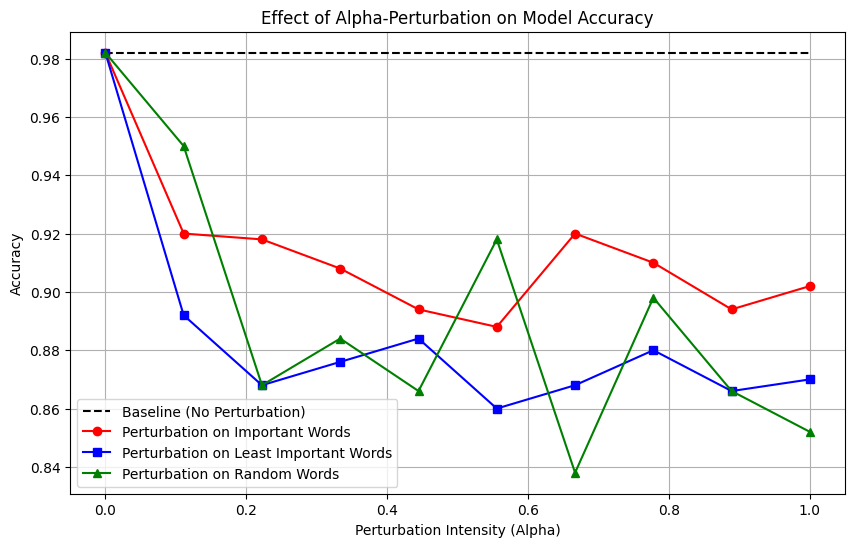

In [ ]:
def perturb_embeddings(inputs, model, indices, epsilon):
    """
    Apply perturbation to embeddings at specific indices.

    Parameters:
    - inputs: Tokenized inputs for BERT
    - model: The BERT model
    - indices: Indices of words to perturb
    - epsilon: Perturbation intensity

    Returns:
    - Perturbed inputs
    """
    with torch.no_grad():
        original_embeddings = model.bert.embeddings.word_embeddings(inputs["input_ids"])

    perturbed_embeddings = original_embeddings.clone()
    for i, idx in enumerate(indices):
        perturbed_embeddings[:, idx] += epsilon * torch.randn_like(perturbed_embeddings[:, idx])

    inputs["inputs_embeds"] = perturbed_embeddings
    del inputs["input_ids"]  # Remove input_ids to avoid conflict

    return inputs

def evaluate_model_with_perturbation(model, tokenizer, dataset, perturb_indices=None, epsilon=0.1):
    """
    Evaluates model accuracy on a test set with optional perturbation.

    Parameters:
    - model: The fine-tuned BERT model
    - tokenizer: BERT tokenizer
    - dataset: Dataset containing test sentences and labels
    - perturb_indices: Indices of words to perturb (None means no perturbation)
    - epsilon: Perturbation intensity

    Returns:
    - Accuracy score
    """
    test_data = dataset["train"].select(range(2001, 2501))
    test_texts = test_data["sentence"]
    test_labels = test_data["label"]

    inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt").to(device)

    if perturb_indices:
        inputs = perturb_embeddings(inputs, model, perturb_indices, epsilon)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
    return accuracy_score(test_labels, predictions)

# Define perturbation intensities
alpha_values = np.linspace(0, 1, 10)

# Store accuracy results
accuracies_baseline = []
accuracies_important = []
accuracies_least_important = []
accuracies_random = []

# Evaluate accuracy for different levels of perturbation
for alpha in alpha_values:
    # Compute baseline accuracy only once
    if not accuracies_baseline:
        clean_accuracy = evaluate_model_with_perturbation(model, tokenizer, dataset, perturb_indices=None)
        accuracies_baseline.append(clean_accuracy)

    # Perturb most important words
    important_accuracy = evaluate_model_with_perturbation(
        model, tokenizer, dataset, perturb_indices=important_indices_rollout, epsilon=alpha
    )
    accuracies_important.append(important_accuracy)

    # Perturb least important words
    least_important_accuracy = evaluate_model_with_perturbation(
        model, tokenizer, dataset, perturb_indices=least_important_indices_rollout, epsilon=alpha
    )
    accuracies_least_important.append(least_important_accuracy)

    # Perturb random words
    random_indices = random.sample(range(len(tokens)), 2)  # Pick 2 random indices
    random_accuracy = evaluate_model_with_perturbation(
        model, tokenizer, dataset, perturb_indices=random_indices, epsilon=alpha
    )
    accuracies_random.append(random_accuracy)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, accuracies_baseline * len(alpha_values), label="Baseline (No Perturbation)", linestyle="--", color="black")
plt.plot(alpha_values, accuracies_important, label="Perturbation on Important Words", marker="o", color="red")
plt.plot(alpha_values, accuracies_least_important, label="Perturbation on Least Important Words", marker="s", color="blue")
plt.plot(alpha_values, accuracies_random, label="Perturbation on Random Words", marker="^", color="green")

plt.xlabel("Perturbation Intensity (Alpha)")
plt.ylabel("Accuracy")
plt.title("Effect of Alpha-Perturbation on Model Accuracy")
plt.legend()
plt.grid(True)
plt.show()

The results are disappointing compared to when we used attention flow. This can be explained by the following reasonning. The discrepancy between attention rollout and attention flow in perturbation experiments highlights a fundamental difference in how these methods compute token importance. Attention rollout accumulates attention across layers, producing a smoother distribution that may overestimate the relevance of less critical tokens. In contrast, attention flow recursively propagates attention, allowing it to better capture the hierarchical structure of importance in Transformer models. This explains why perturbing high-flow words led to a more significant accuracy drop, while perturbing high-rollout words had a more limited effect—the latter were not necessarily driving the model’s final decision.